In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlpdataset/1-P-3-ISEAR.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
import torch
import torch.nn as nn

In [3]:
emotion_df = pd.read_csv("/kaggle/input/nlpdataset/1-P-3-ISEAR.csv",header=None)
emotion_df.head()

,0,1,2
0,0,joy,On days when I feel close to my partner and ot...
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...


In [4]:
emotion_df.columns = ['sn','Target','Sentence']
emotion_df.drop('sn',inplace=True,axis =1)
emotion_df.head()

,Target,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [5]:
emotion_df.duplicated().sum()

55

In [6]:
emotion_df.drop_duplicates(inplace = True)

In [7]:
emotion_df['Target'].value_counts()

joy        1071
anger      1069
fear       1059
disgust    1058
shame      1049
sadness    1046
guilt      1039
Name: Target, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
emotion_df['Target'] = le.fit_transform(emotion_df['Target'])

In [9]:
def lowercase(text):
    '''a function lowercasing all characters'''
    text = text.lower()
    return text

emotion_df['Sentence'] = emotion_df['Sentence'].apply(lowercase)

In [10]:
import string

def remove_punct_num(text):
    '''a function for removing punctuation and number'''
    text = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    return text


emotion_df['Sentence'] = emotion_df['Sentence'].apply(remove_punct_num)

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
stop_words = stopwords.words('english')

In [13]:
exceptionStopWords = {'aren',"aren't",
                      'cannot','couldn',"couldn't",
                      'didn',"didn't",'doesn',"doesn't",'don',"don't",
                      'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",
                      'isn',"isn't",
                      'mightn',"mightn't",'must','mustn',"mustn't",
                      'needn',"needn't",'neither','never','nevertheless','no','nobody','none','noone','nor','not','nothing',
                      'should',"should've",'shouldn',"shouldn't",
                      'wasn',"wasn't",'weren',"weren't","won't",'wouldn',"wouldn't",
                    }

In [14]:
final_stop_words = set(stop_words)-exceptionStopWords

In [15]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    """
    text = [w for w in text.split() if w not in final_stop_words]
    return ' '.join(text)

emotion_df['Sentence'] = emotion_df['Sentence'].apply(remove_stopwords)

In [16]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
from nltk import pos_tag,word_tokenize
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    """
    converting words to it's root form
    """
    tmp_txt = []
    for token,tag in pos_tag(word_tokenize(text)):
        pos=tag[0].lower()
            
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        
        tmp_txt.append(lemmatizer.lemmatize(token,pos))
    return tmp_txt

emotion_df['Sentence'] = emotion_df['Sentence'].apply(lemmatize)


In [18]:
emotion_df.head()

,Target,Sentence
0,4,"[day, feel, close, partner, friend, feel, peac..."
1,2,"[every, time, imagine, someone, love, could, c..."
2,0,"[obviously, unjustly, treat, no, possibility, ..."
3,5,"[think, short, time, live, relate, period, lif..."
4,1,"[gather, find, involuntarily, sit, next, two, ..."


In [19]:
from sklearn.model_selection import train_test_split

X = emotion_df['Sentence']
y = emotion_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=10)

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [21]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]

In [22]:
doc_model = Doc2Vec(documents, vector_size=50, window=2, min_count=2, workers=4)

In [23]:
def get_sent_vectors(data):
    data_vectors = []
    for sent in data:
        data_vectors.append(doc_model.infer_vector(sent))
    return data_vectors

In [24]:
train_sent_vectors = get_sent_vectors(X_train)
test_sent_vectors = get_sent_vectors(X_test)

In [25]:
train_sent_vectors = np.array(train_sent_vectors)
test_sent_vectors = np.array(test_sent_vectors)

In [26]:
train_labels = np.array(y_train)
test_labels = np.array(y_test)

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

train_data = TensorDataset(torch.from_numpy(train_sent_vectors), torch.squeeze(torch.from_numpy(train_labels)))
test_data = TensorDataset(torch.from_numpy(test_sent_vectors), torch.squeeze(torch.from_numpy(test_labels)))

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [28]:
train_data[0]

(tensor([-0.0255, -0.0024, -0.0114, -0.0096,  0.0114, -0.0678,  0.0456,  0.0811,
         -0.1063,  0.0075,  0.0050, -0.0793,  0.0111,  0.0210, -0.0431,  0.0113,
          0.0307, -0.0336, -0.0641, -0.0484, -0.0081,  0.0290,  0.1107, -0.0290,
          0.0702,  0.0030, -0.0357, -0.0291, -0.1114, -0.0047,  0.0369,  0.0373,
         -0.0368,  0.0329, -0.0558,  0.0637, -0.0011,  0.0111,  0.0476, -0.0255,
          0.0469,  0.0078, -0.0272,  0.0134,  0.1039,  0.0180, -0.0095, -0.0660,
          0.0261,  0.0188]),
 tensor(4))

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size,output_size, embedding_dim, hidden_size, num_layers,dropout = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers,
                            dropout = dropout,
                            batch_first = True,
                            bidirectional = True)
        self.linear = nn.Linear(hidden_size*2, output_size)
        
    def forward(self, inputs):
        emb = self.embedding(inputs)
        
        h0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        
        lstm_out, h = self.lstm(emb, (h0, c0))
        
        lstm_out = lstm_out[:, -1, :]
        
        lstm_out = F.dropout(lstm_out, 0.1)
        
        output = self.linear(lstm_out)
        
        return output


In [31]:
vocab = len(doc_model.wv.index_to_key)
print(vocab)

3312


In [32]:
vocab_size = vocab + 1
embedding_dim = 50
hidden_dim = 32
n_layers = 2
output_size = 7


model = LSTMModel(vocab_size,output_size, embedding_dim, hidden_dim, n_layers).to(device)

In [33]:
model

LSTMModel(
  (embedding): Embedding(3313, 50)
  (lstm): LSTM(50, 32, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=64, out_features=7, bias=True)
)

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
num_epochs  = 5

loss_list = []
iteration_list_train = []
count_train = 0

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Compute the forward pass through the network up to the loss
            outputs = model(inputs.long())

            loss = criterion(outputs, targets)

            loss_list.append(loss.data) 

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            count_train += 1
            iteration_list_train.append(count_train) 

            if (i+1) % 10 == 0:                    
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, len(train_data)//128, loss.item()))
  

Epoch [1/5], Step [10/46], Loss: 1.9480
Epoch [1/5], Step [20/46], Loss: 1.9541
Epoch [1/5], Step [30/46], Loss: 1.9547
Epoch [1/5], Step [40/46], Loss: 1.9498
Epoch [2/5], Step [10/46], Loss: 1.9492
Epoch [2/5], Step [20/46], Loss: 1.9482
Epoch [2/5], Step [30/46], Loss: 1.9444
Epoch [2/5], Step [40/46], Loss: 1.9484
Epoch [3/5], Step [10/46], Loss: 1.9444
Epoch [3/5], Step [20/46], Loss: 1.9525
Epoch [3/5], Step [30/46], Loss: 1.9483
Epoch [3/5], Step [40/46], Loss: 1.9524
Epoch [4/5], Step [10/46], Loss: 1.9529
Epoch [4/5], Step [20/46], Loss: 1.9430
Epoch [4/5], Step [30/46], Loss: 1.9411
Epoch [4/5], Step [40/46], Loss: 1.9477
Epoch [5/5], Step [10/46], Loss: 1.9442
Epoch [5/5], Step [20/46], Loss: 1.9430
Epoch [5/5], Step [30/46], Loss: 1.9448
Epoch [5/5], Step [40/46], Loss: 1.9439


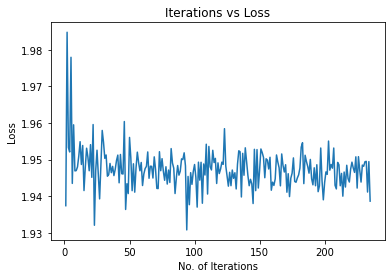

In [37]:
import matplotlib.pyplot as plt

plt.plot(iteration_list_train, loss_list)
plt.xlabel("No. of Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [38]:
accuracy_list = []
iteration_list_test = []
count_test = 0

y_pred = []
y_true = []

correct = 0
total = 0
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs.long())
    _, predicted = torch.max(outputs.data, 1)

    total += targets.size(0)                    
    correct += (predicted == targets).sum()    

    count_test += 1
    iteration_list_test.append(count_test)  

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
    y_pred.extend(predicted.cpu())
    y_true.extend(targets.cpu())
    
print('Accuracy of the network on the test: %d %%' %accuracy)

Accuracy of the network on the test: 12 %


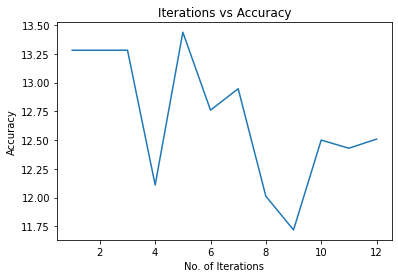

In [39]:
plt.plot(iteration_list_test, accuracy_list)
plt.xlabel("No. of Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()